# Classification II – Sentiment Analysis

## Fetching the Twitter data
### install.py

In [109]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

#
# Sanders-Twitter Sentiment Corpus Install Script
# Version 0.1
#
# Pulls tweet data from Twitter because ToS prevents distributing it directly.
#
#   - Niek Sanders
#     njs@sananalytics.com
#     October 20, 2011
#
#

# In Sanders' original form, the code was using Twitter API 1.0.
# Now that Twitter moved to 1.1, we had to make a few changes.
# Cf. twitterauth.py for the details.

# Regarding rate limiting, please check
# https://dev.twitter.com/rest/public/rate-limiting

import sys
import csv
import json
import os
import time

try:
    import twitter
except ImportError:
    print("""\
You need to ...
    pip install twitter
If pip is not found you might have to install it using easy_install.
If it does not work on your system, you might want to follow instructions
at https://github.com/sixohsix/twitter, most likely:
  $ git clone https://github.com/sixohsix/twitter
  $ cd twitter
  $ sudo python setup.py install
""")

    sys.exit(1)



In [110]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

import sys

CONSUMER_KEY = 'L2vTebGpgm5QSukyUSkl1bFYy'
CONSUMER_SECRET ='X82lfZQwbVaFWbWQRvrvT0kzP0nMsWXKNgpSl1ATeqFt0uiZ1A'

ACCESS_TOKEN_KEY ='748183043609755648-4HggvL6t6KEHKpY1VEjfGYUQLMLVkje'
ACCESS_TOKEN_SECRET ='8eI9FFdz6EV1XybNlp8hYw8n3r6VGlnn129GbBLU928Sh'

if CONSUMER_KEY is None or CONSUMER_SECRET is None or ACCESS_TOKEN_KEY is None or ACCESS_TOKEN_SECRET is None:
    print("""\
When doing last code sanity checks for the book, Twitter
was using the API 1.0, which did not require authentication.
With its switch to version 1.1, this has now changed.
It seems that you don't have already created your personal Twitter
access keys and tokens. Please do so at
https://dev.twitter.com/docs/auth/tokens-devtwittercom
and paste the keys/secrets into twitterauth.py
Sorry for the inconvenience,
The authors.""")

    sys.exit(1)

In [111]:
api = twitter.Twitter(auth=twitter.OAuth(consumer_key=CONSUMER_KEY, consumer_secret=CONSUMER_SECRET,
                                         token=ACCESS_TOKEN_KEY, token_secret=ACCESS_TOKEN_SECRET))

DATA_PATH = "data"

# for some reasons TWeets disappear. In this file we collect those
MISSING_ID_FILE = os.path.join(DATA_PATH, "missing.tsv")
NOT_AUTHORIZED_ID_FILE = os.path.join(DATA_PATH, "not_authorized.tsv")

In [112]:
def get_user_params(DATA_PATH):

    user_params = {}

    # get user input params
    user_params['inList'] = os.path.join(DATA_PATH, 'corpus.csv')
    user_params['outList'] = os.path.join(DATA_PATH, 'full-corpus.csv')
    user_params['rawDir'] = os.path.join(DATA_PATH, 'rawdata/')

    # apply defaults
    if user_params['inList'] == '':
        user_params['inList'] = './corpus.csv'
    if user_params['outList'] == '':
        user_params['outList'] = './full-corpus.csv'
    if user_params['rawDir'] == '':
        user_params['rawDir'] = './rawdata/'

    return user_params



In [113]:

def dump_user_params(user_params):

    # dump user params for confirmation
    print('Input:    ' + user_params['inList'])
    print('Output:   ' + user_params['outList'])
    print('Raw data: ' + user_params['rawDir'])


In [114]:


def read_total_list(in_filename):

    # read total fetch list csv
    fp = open(in_filename, 'rt')
    reader = csv.reader(fp, delimiter=',', quotechar='"')

    if os.path.exists(MISSING_ID_FILE):
        missing_ids = [line.strip()
                       for line in open(MISSING_ID_FILE, "r").readlines()]
    else:
        missing_ids = []

    if os.path.exists(NOT_AUTHORIZED_ID_FILE):
        not_authed_ids = [line.strip()
                          for line in open(NOT_AUTHORIZED_ID_FILE, "r").readlines()]
    else:
        not_authed_ids = []

    print("We will skip %i tweets that are not available or visible any more on twitter" % (
        len(missing_ids) + len(not_authed_ids)))

    ignore_ids = set(missing_ids + not_authed_ids)
    total_list = []

    for row in reader:
        if row[2] not in ignore_ids:
            total_list.append(row)

    return total_list



In [115]:

def purge_already_fetched(fetch_list, raw_dir):

    # list of tweet ids that still need downloading
    rem_list = []
    count_done = 0

    # check each tweet to see if we have it
    for item in fetch_list:

        # check if json file exists
        tweet_file = os.path.join(raw_dir, item[2] + '.json')
        if os.path.exists(tweet_file):

            # attempt to parse json file
            try:
                parse_tweet_json(tweet_file)
                count_done += 1
            except RuntimeError:
                print("Error parsing", item)
                rem_list.append(item)
        else:
            rem_list.append(item)

    print("We have already downloaded %i tweets." % count_done)

    return rem_list


In [116]:
def download_tweets(fetch_list, raw_dir):

    # ensure raw data directory exists
    if not os.path.exists(raw_dir):
        os.mkdir(raw_dir)
        
        # stay within rate limits
    max_tweets_per_hr  = 125
    download_pause_sec = 3600 / max_tweets_per_hr


    # download tweets
    for idx in range(0, len(fetch_list)):
        # current item
        item = fetch_list[idx]
        print(item)

        print('--> downloading tweet #%s (%d of %d)' %
              (item[2], idx + 1, len(fetch_list)))

        try:
            #import pdb;pdb.set_trace()
            response = api.statuses.show(_id=item[2])

            if response.rate_limit_remaining <= 0:
                wait_seconds = response.rate_limit_reset - time.time()
                print("Rate limiting requests us to wait %f seconds" %
                      wait_seconds)
                time.sleep(wait_seconds+5)

        except twitter.TwitterError as e:
            fatal = True
            print(e)
            for m in json.loads(e.response_data.decode())['errors']:
                if m['code'] == 34:
                    print("Tweet missing: ", item)
                    with open(MISSING_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")

                    fatal = False
                    break
                elif m['code'] == 63:
                    print("User of tweet '%s' has been suspended." % item)
                    with open(MISSING_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")

                    fatal = False
                    break
                elif m['code'] == 88:
                    print("Rate limit exceeded.")
                    fatal = True
                    break
                elif m['code'] == 179:
                    print("Not authorized to view this tweet.")
                    with open(NOT_AUTHORIZED_ID_FILE, "at") as f:
                        f.write(item[2] + "\n")
                    fatal = False
                    break

            if fatal:
                raise
            else:
                continue

        with open(raw_dir + item[2] + '.json', "wt") as f:
            f.write(json.dumps(dict(response)) + "\n")
            
         # stay in Twitter API rate limits 
        print ('    pausing %d sec to obey Twitter API rate limits' % \
              (download_pause_sec))
        time.sleep( download_pause_sec )

    return


In [117]:


def parse_tweet_json(filename):

    # read tweet
    fp = open(filename, 'r')

    # parse json
    try:
        tweet_json = json.load(fp)
    except ValueError as e:
        print(e)
        raise RuntimeError('error parsing json')

    # look for twitter api error msgs
    if 'error' in tweet_json or 'errors' in tweet_json:
        raise RuntimeError('error in downloaded tweet')

    # extract creation date and tweet text
    return [tweet_json['created_at'], tweet_json['text']]



In [118]:

def build_output_corpus(out_filename, raw_dir, total_list):

    # open csv output file
    fp = open(out_filename, 'wb')
    writer = csv.writer(fp, delimiter=',', quotechar='"', escapechar='\\',
                        quoting=csv.QUOTE_ALL)

    # write header row
    writer.writerow(
        ['Topic', 'Sentiment', 'TweetId', 'TweetDate', 'TweetText'])

    # parse all downloaded tweets
    missing_count = 0
    for item in total_list:

        # ensure tweet exists
        if os.path.exists(raw_dir + item[2] + '.json'):

            try:
                # parse tweet
                parsed_tweet = parse_tweet_json(raw_dir + item[2] + '.json')
                full_row = item + parsed_tweet

                # character encoding for output
                for i in range(0, len(full_row)):
                    full_row[i] = full_row[i].encode("utf-8")

                # write csv row
                writer.writerow(full_row)

            except RuntimeError:
                print('--> bad data in tweet #' + item[2])
                missing_count += 1

        else:
            print('--> missing tweet #' + item[2])
            missing_count += 1

    # indicate success
    if missing_count == 0:
        print('\nSuccessfully downloaded corpus!')
        print('Output in: ' + out_filename + '\n')
    else:
        print('\nMissing %d of %d tweets!' % (missing_count, len(total_list)))
        print('Partial output in: ' + out_filename + '\n')

    return



In [121]:

def main():
    # get user parameters
    user_params = get_user_params(DATA_PATH)
    print(user_params)
    dump_user_params(user_params)

    # get fetch list
    total_list = read_total_list(user_params['inList'])

    # remove already fetched or missing tweets
    fetch_list = purge_already_fetched(total_list, user_params['rawDir'])
    print("Fetching %i tweets..." % len(fetch_list))

    if fetch_list:
        # start fetching data from twitter
        download_tweets(fetch_list, user_params['rawDir'])

        # second pass for any failed downloads
        fetch_list = purge_already_fetched(total_list, user_params['rawDir'])
        if fetch_list:
            print('\nStarting second pass to retry %i failed downloads...' %
                  len(fetch_list))
            download_tweets(fetch_list, user_params['rawDir'])
    else:
        print("Nothing to fetch any more.")

    # build output corpus
    build_output_corpus(user_params['outList'], user_params['rawDir'],
                        total_list)


if __name__ == '__main__':
    main()


{'inList': 'data\\corpus.csv', 'outList': 'data\\full-corpus.csv', 'rawDir': 'data\\rawdata/'}
Input:    data\corpus.csv
Output:   data\full-corpus.csv
Raw data: data\rawdata/
We will skip 1108 tweets that are not available or visible any more on twitter
We have already downloaded 1413 tweets.
Fetching 3370 tweets...
['apple', 'positive', '126148685737361408']
--> downloading tweet #126148685737361408 (1 of 3370)
Twitter sent status 404 for URL: 1.1/statuses/show.json using parameters: (id=126148685737361408&oauth_consumer_key=L2vTebGpgm5QSukyUSkl1bFYy&oauth_nonce=419581646483059077&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1549737260&oauth_token=748183043609755648-4HggvL6t6KEHKpY1VEjfGYUQLMLVkje&oauth_version=1.0&oauth_signature=sSnwV2t%2BIF2U1dGgGQo2waSkFQA%3D)
details: b'{"errors":[{"code":144,"message":"No status found with that ID."}]}'


TwitterHTTPError: Twitter sent status 404 for URL: 1.1/statuses/show.json using parameters: (id=126148685737361408&oauth_consumer_key=L2vTebGpgm5QSukyUSkl1bFYy&oauth_nonce=419581646483059077&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1549737260&oauth_token=748183043609755648-4HggvL6t6KEHKpY1VEjfGYUQLMLVkje&oauth_version=1.0&oauth_signature=sSnwV2t%2BIF2U1dGgGQo2waSkFQA%3D)
details: b'{"errors":[{"code":144,"message":"No status found with that ID."}]}'

<Figure size 432x288 with 0 Axes>

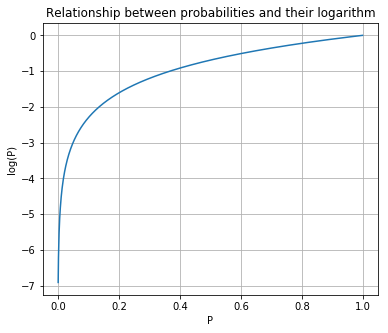

In [123]:
# This code is supporting material for the book
# Building Machine Learning Systems with Python
# by Willi Richert and Luis Pedro Coelho
# published by PACKT Publishing
#
# It is made available under the MIT License

import os
import sys
import collections
import csv
import json

from matplotlib import pylab
import numpy as np


DATA_DIR = "data"
CHART_DIR = "charts"

if not os.path.exists(DATA_DIR):
    raise RuntimeError("Expecting directory 'data' in current path")

if not os.path.exists(CHART_DIR):
    os.mkdir(CHART_DIR)


def tweak_labels(Y, pos_sent_list):
    pos = Y == pos_sent_list[0]
    for sent_label in pos_sent_list[1:]:
        pos |= Y == sent_label

    Y = np.zeros(Y.shape[0])
    Y[pos] = 1
    Y = Y.astype(int)

    return Y


def load_sanders_data(dirname=".", line_count=-1):
    count = 0

    topics = []
    labels = []
    tweets = []

    with open(os.path.join(DATA_DIR, dirname, "corpus.csv"), "r") as csvfile:
        metareader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in metareader:
            count += 1
            if line_count > 0 and count > line_count:
                break

            topic, label, tweet_id = line

            tweet_fn = os.path.join(
                DATA_DIR, dirname, 'rawdata', '%s.json' % tweet_id)
            try:
                tweet = json.load(open(tweet_fn, "r"))
            except IOError:
                print(("Tweet '%s' not found. Skip." % tweet_fn))
                continue

            if 'text' in tweet and tweet['user']['lang'] == "en":
                topics.append(topic)
                labels.append(label)
                tweets.append(tweet['text'])

    tweets = np.asarray(tweets)
    labels = np.asarray(labels)

    return tweets, labels


def plot_pr(auc_score, name, phase, precision, recall, label=None):
    pylab.clf()
    pylab.figure(num=None, figsize=(5, 4))
    pylab.grid(True)
    pylab.fill_between(recall, precision, alpha=0.5)
    pylab.plot(recall, precision, lw=1)
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('P/R curve (AUC=%0.2f) / %s' % (auc_score, label))
    filename = name.replace(" ", "_")
    pylab.savefig(os.path.join(CHART_DIR, "pr_%s_%s.png" %
                               (filename, phase)), bbox_inches="tight")


def show_most_informative_features(vectorizer, clf, n=20):
    c_f = sorted(zip(clf.coef_[0], vectorizer.get_feature_names()))
    top = list(zip(c_f[:n], c_f[:-(n + 1):-1]))
    for (c1, f1), (c2, f2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (c1, f1, c2, f2))


def plot_log():
    pylab.clf()
    pylab.figure(num=None, figsize=(6, 5))

    x = np.arange(0.001, 1, 0.001)
    y = np.log(x)

    pylab.title('Relationship between probabilities and their logarithm')
    pylab.plot(x, y)
    pylab.grid(True)
    pylab.xlabel('P')
    pylab.ylabel('log(P)')
    filename = 'log_probs.png'
    pylab.savefig(os.path.join(CHART_DIR, filename), bbox_inches="tight")


def plot_feat_importance(feature_names, clf, name):
    pylab.clf()
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    pylab.bar(xpos, coef, width=1)

    pylab.title('Feature importance for %s' % (name))
    ax = pylab.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")
    pylab.savefig(os.path.join(
        CHART_DIR, "feat_imp_%s.png" % filename), bbox_inches="tight")


def plot_feat_hist(data_name_list, filename=None):
    pylab.clf()
    num_rows = 1 + (len(data_name_list) - 1) / 2
    num_cols = 1 if len(data_name_list) == 1 else 2
    pylab.figure(figsize=(5 * num_cols, 4 * num_rows))

    for i in range(num_rows):
        for j in range(num_cols):
            pylab.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            pylab.title(name)
            pylab.xlabel('Value')
            pylab.ylabel('Density')
            # the histogram of the data
            max_val = np.max(x)
            if max_val <= 1.0:
                bins = 50
            elif max_val > 50:
                bins = 50
            else:
                bins = max_val
            n, bins, patches = pylab.hist(
                x, bins=bins, normed=1, facecolor='green', alpha=0.75)

            pylab.grid(True)

    if not filename:
        filename = "feat_hist_%s.png" % name

    pylab.savefig(os.path.join(CHART_DIR, filename), bbox_inches="tight")


def plot_bias_variance(data_sizes, train_errors, test_errors, name):
    pylab.clf()
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Data set size')
    pylab.ylabel('Error')
    pylab.title("Bias-Variance for '%s'" % name)
    pylab.plot(
        data_sizes, train_errors, "-", data_sizes, test_errors, "--", lw=1)
    pylab.legend(["train error", "test error"], loc="upper right")
    pylab.grid()
    pylab.savefig(os.path.join(CHART_DIR, "bv_" + name + ".png"))


def load_sent_word_net():

    sent_scores = collections.defaultdict(list)
    sentiwordnet_path = os.path.join(DATA_DIR, "SentiWordNet_3.0.0_20130122.txt")

    if not os.path.exists(sentiwordnet_path):
        print("Please download SentiWordNet_3.0.0 from http://sentiwordnet.isti.cnr.it/download.php, extract it and put it into the data directory")
        sys.exit(1)

    with open(sentiwordnet_path, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='"')
        for line in reader:
            if line[0].startswith("#"):
                continue
            if len(line) == 1:
                continue

            POS, ID, PosScore, NegScore, SynsetTerms, Gloss = line
            if len(POS) == 0 or len(ID) == 0:
                continue
            # print POS,PosScore,NegScore,SynsetTerms
            for term in SynsetTerms.split(" "):
                # drop #number at the end of every term
                term = term.split("#")[0]
                term = term.replace("-", " ").replace("_", " ")
                key = "%s/%s" % (POS, term.split("#")[0])
                sent_scores[key].append((float(PosScore), float(NegScore)))
    for key, value in sent_scores.items():
        sent_scores[key] = np.mean(value, axis=0)

    return sent_scores


def log_false_positives(clf, X, y, name):
    with open("FP_" + name.replace(" ", "_") + ".tsv", "w") as f:
        false_positive = clf.predict(X) != y
        for tweet, false_class in zip(X[false_positive], y[false_positive]):
            f.write("%s\t%s\n" %
                    (false_class, tweet.encode("ascii", "ignore")))


if __name__ == '__main__':
    plot_log()

In [127]:
>>> X, Y = load_sanders_data()
>>> classes = np.unique(Y)
>>> for c in classes: print("#%s: %i" % (c, sum(Y==c)))

Tweet 'data\.\rawdata\126366123368267776.json' not found. Skip.
Tweet 'data\.\rawdata\126354605130002432.json' not found. Skip.
Tweet 'data\.\rawdata\126350948548354048.json' not found. Skip.
Tweet 'data\.\rawdata\126344048637259776.json' not found. Skip.
Tweet 'data\.\rawdata\126323785145126912.json' not found. Skip.
Tweet 'data\.\rawdata\126312877916307458.json' not found. Skip.
Tweet 'data\.\rawdata\126267185025916928.json' not found. Skip.
Tweet 'data\.\rawdata\126213333123743744.json' not found. Skip.
Tweet 'data\.\rawdata\126148685737361408.json' not found. Skip.
Tweet 'data\.\rawdata\126130991365500928.json' not found. Skip.
Tweet 'data\.\rawdata\126093298619252737.json' not found. Skip.
Tweet 'data\.\rawdata\126079414986485761.json' not found. Skip.
Tweet 'data\.\rawdata\126059399319003136.json' not found. Skip.
Tweet 'data\.\rawdata\126039929523404801.json' not found. Skip.
Tweet 'data\.\rawdata\126015087386431488.json' not found. Skip.
Tweet 'data\.\rawdata\125979338846900224

Tweet 'data\.\rawdata\125559846870323200.json' not found. Skip.
Tweet 'data\.\rawdata\125559232157327360.json' not found. Skip.
Tweet 'data\.\rawdata\125551370676862976.json' not found. Skip.
Tweet 'data\.\rawdata\125538769632886784.json' not found. Skip.
Tweet 'data\.\rawdata\125532364406398977.json' not found. Skip.
Tweet 'data\.\rawdata\125532202057482240.json' not found. Skip.
Tweet 'data\.\rawdata\125493125098635265.json' not found. Skip.
Tweet 'data\.\rawdata\125459423870197760.json' not found. Skip.
Tweet 'data\.\rawdata\125459375245635584.json' not found. Skip.
Tweet 'data\.\rawdata\125417324621737985.json' not found. Skip.
Tweet 'data\.\rawdata\125379023307153408.json' not found. Skip.
Tweet 'data\.\rawdata\125374041556127744.json' not found. Skip.
Tweet 'data\.\rawdata\125365963972542464.json' not found. Skip.
Tweet 'data\.\rawdata\125365264656236544.json' not found. Skip.
Tweet 'data\.\rawdata\125364122853453824.json' not found. Skip.
Tweet 'data\.\rawdata\125354296752619520

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [126]:
try:
    tweet = json.load(open('data/rawdata/126366123368267776.json', "r"))
except IOError:
    print("Tweet not found. Skip.")
    


Tweet not found. Skip.
